In [ ]:
import pandas as pd
import numpy as np
import matplotlib_venn as mv

df_original = pd.read_csv("contrib_from_original.csv", sep = ",", dtype= str)
df_processed = pd.read_csv("contrib_from_csv.csv", sep = ",", dtype= str)

#  focntion pour afficher la totalité du dataframe (utiliser seulement pour de petits bouts de df)
def print_full(df):
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')


In [ ]:
print("y a t il des nan? ->",df_original.isnull().values.any())
print("combien y a t il de nan? ->",df_original.isnull().values.sum())
print("où sont les null? ->\n",df_original.isnull().sum())
print("un df avec les null si il y en a :\n")
df_original[df_original.isnull().T.any()]

In [ ]:
# vérifier qu'il n'y a que les contributions viennent toutes des cahiers citoyens

print(pd.unique(df_processed["Catégorie"]))
print(pd.unique(df_original["Catégorie"]))

In [ ]:
# testé : il n'y a pas de DUPLICATE

# pour trouver toutes les contribution à partir d'un contenu avec un nom de colonne :
print(df_original[df_original["Code postal"] == "77000"])

In [ ]:
# le nombre de contributions pour chaque id de carnet, 
# aussi comptabilisé pour avoir un niveau de comparaison avec le df des originaux bruts

group1 = pd.DataFrame({'count' : df_processed.groupby( ["joined_id"] ).size()}).reset_index()

print(group1)

In [62]:
# renommer les noms de colonnes pour pv merge

df_original = df_original.rename(columns={"info_communes": "joined_id"})
df_original = df_original.rename(columns={"Numéro d'id_cc": "Numéro d'ordre arbitraire"})


# merge sur les noms de dossiers

mergedStuff = pd.merge(df_original["joined_id"], group1["joined_id"],
                how='outer', indicator=True)

# original qui n'existent pas dans processed (noms de dossiers)

left_only = mergedStuff.loc[mergedStuff["_merge"] == "left_only"]


# processed qui n'existe pas original (noms de dossiers)

right_only = mergedStuff.loc[mergedStuff["_merge"] == "right_only"]

# nombre de différences pour les deux

print("left_only.shape", left_only)
print("right_only.shape", right_only.shape)
right_only

left_only.shape                             joined_id     _merge
13     CC_00000_190225_00000_MD_04597  left_only
14     CC_00000_190225_00000_MD_04657  left_only
15     CC_00000_190225_00000_MD_06064  left_only
17     CC_00000_190225_00000_MD_11900  left_only
21     CC_00000_190228_00000_MD_13165  left_only
...                               ...        ...
19856  CC_78650_190409_78062_MD_20167  left_only
19859  CC_78660_190225_78071_MD_02632  left_only
19860  CC_78660_190225_78506_MD_02802  left_only
19872  CC_78730_190225_78349_MD_02697  left_only
19886  CC_78780_190409_78382_MD_20163  left_only

[928 rows x 2 columns]
right_only.shape (314, 2)


,joined_id,_merge
19930,CC_00000_190121_00000_MD_06064,right_only
19931,CC_0000_190225_00000_MD_04597,right_only
19932,CC_0000_190225_00000_MD_11900,right_only
19933,CC_0000_190228_00000_MD_13165,right_only
19934,CC_0000_190301_00000_MD_14163,right_only
...,...,...
20239,CC_89450_190318_89446_MD_10336,right_only
20240,CC_89660_190320_89253_MD_10269,right_only
20241,CC_93190_190320_93046_MD_15311,right_only
20242,CC_97141_190402_97133_MD_17336,right_only


In [63]:
# cree une colonne DEPARTEMENTS pour les datas processed en prenant les deux premiers chiffres du code postal

df_processed["departement"] = df_processed["Code postal"].astype(str).str[:2]


# pour les communes qui ne partagent pas leur n° de département avec leur insee, j'utilise le même classement que l'original AN (code postal > code insee).
# un code postal englobe plusieurs communes avec plusieurs numero insee

# cree une colonne departement pour les datas brutes à partir du code postal aussi

df_original["departement"] = df_original["Code postal"].astype(str).str[:2]



In [65]:
# choix de la variable à merge | à exploiter | à extraire :
# un indice pour choisir la variable à tester (numéro arbitraire -aka id carnet- ne s'applique qu'aux comparaison inter corpus)

info_recherche = ["Code INSEE", "departement", "Numéro d'ordre arbitraire"]
noms = ["Communes", "Départements", "Cahiers"]
choix = 0

In [ ]:
# compte le nombre de contributions pour chaque code

processed_groupdf = df_processed.groupby([info_recherche[choix]]).size().reset_index()
print("taille du groupby applqié sur le fichier processed",processed_groupdf)


# merge outer entre processed et original selon l'indice choix (commune ou dpt ou id carnet)

uniques_original = pd.DataFrame(pd.unique(df_original[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop=True)
print("uniques_original.shape : ",uniques_original.shape)
print("original.shape : ",df_original.shape)

uniques_processed = pd.DataFrame(pd.unique(df_processed[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop = True)
print("uniques_processed.shape : ",uniques_processed.shape)
print("processed.shape : ",df_processed.shape)

merge_df = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='outer', indicator='source')
# NOTE : ceux là peuvent être comparés entre eux car ils sont le même type d'objet
print(merge_df)
# fait deux merge, un sur le outer left et un sur le outer right pour récup les codes exclus chacuns par l'autre
# processed vs. original + ecrit les listes exclues de chacuns dans un csv

dict_of_df = {}
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["original", "derivé csv"]
    result = merge_df[merge_df.source.eq(mer[i])].drop('source', axis=1)
    print(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_original_vs_processed.csv", [info_recherche[choix]])
    print("MERGE result shape : "+nam[i], result.shape)
    print(result[info_recherche[choix]])
    result.to_csv("NEW"+noms[choix]+"_seulement_dans_"+nam[i]+"_pour_original_vs_processed.csv", columns=[info_recherche[choix]], index = False)

merge_df[merge_df.source.eq("both")].drop('source', axis=1)

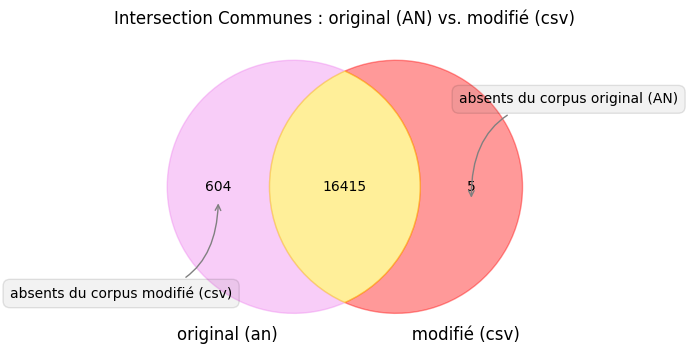

In [67]:
# affiche les intersections - exclusions du merge original vs. processed
# les montre (venn diagram) et les sauvegarde

from matplotlib import pyplot as plt

inner_merged = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='inner', indicator='source')

# define size of figure

plt.figure(figsize=(8,4))

v = mv.venn2_unweighted([set(list(df_original[info_recherche[choix]])), set(list(df_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))
# mêmes resultats avec :
# v = mv.venn2([set(list(uniques_original[info_recherche[choix]])), set(list(uniques_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))

# choose color

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('11').set_color('gold')


# choose title

plt.title("Intersection "+noms[choix]+" : original (AN) vs. modifié (csv)")

# add some texts

plt.annotate('absents du corpus modifié (csv)', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents du corpus original (AN)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show(v)
# plt.savefig("original_vs_modifie_"+noms[choix]+".png", format = "png", dpi = 800)
# savefig du vide pour l'instant


In [ ]:
# comparaison insee stats vs. corpus processed stats
# sauvegarde l'exclusion de chaque en csv
# retrieve insee datas from insee csv
# retrieve dept or communes values only, from insee df into a df and rename the column

if choix == 0 :
    df_communes = pd.read_csv("../Téléchargements/cog_ensemble_2019_csv/communes-01012019.csv", sep = ",")
    df_insee = pd.Series(df_communes["com"], name=info_recherche[choix]).reset_index(drop = True)

# retrieve departement if choice  = 1 (departement) or 2 (cahier) but useless for cahier (no cahier in insee docs ofc)
else :
    df_departement = pd.read_csv("../Téléchargements/cog_ensemble_2019_csv/departement2019.csv", sep = ",")
    df_insee = pd.Series(df_departement["dep"], name=info_recherche[choix]).reset_index(drop = True)


# create a df with departement only from the processed df (csv), sort them -> they now can be used on compare with insee sheets (bc same order, also same objects types I guessed)

processed_compare_df = pd.unique(df_processed[info_recherche[choix]])
processed_compare_df = pd.Series(np.sort(processed_compare_df), name=info_recherche[choix], dtype=str).reset_index(drop = True)
shape_processed = processed_compare_df.shape

# merge the two

merged_df = pd.merge(df_insee.astype(str), processed_compare_df.astype(str), how='outer', indicator='source')
print(uniques_processed)

# compare the two series and save the exclusion of each
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "processed"]
    result = merged_df[merged_df.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)
    print(nam[i]," shape\n",  result.shape)
    result = merged_df[merged_df.source.eq(mer[i])].drop('source', axis=1)
    result.to_csv("NEW"+noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_processed.csv", columns=[info_recherche[choix]], index = False)


In [ ]:
compare_original = pd.unique(df_original[info_recherche[choix]])
compare_original = pd.Series(np.sort(compare_original), name=info_recherche[choix], dtype=str).reset_index(drop = True)

merged_df = pd.merge(df_insee.astype(str), compare_original.astype(str), how='inner')
third_merge = pd.merge(merged_df.astype(str), processed_compare_df.astype(str), how='inner')

# print(uniques_processed)
print("third_merge","\n",  third_merge)
print("third_merge"," shape\n",  third_merge.shape)


Text(70, 70, "absents de l'insee,\nprésents dans corpus modifié (csv)")

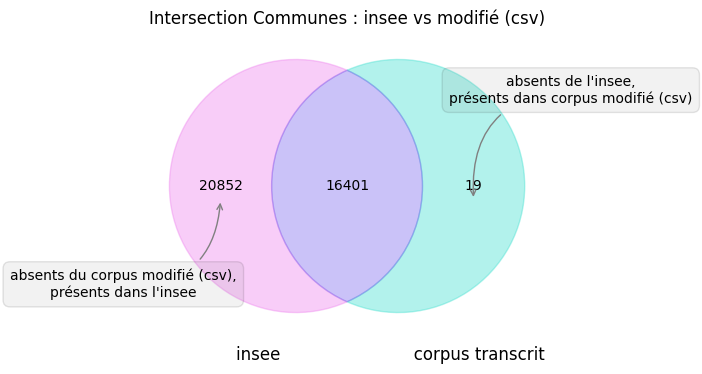

In [70]:
# show inclusion exclusion with venn diagram for insee vs. processed
# sauvegarde le diagramme de venn

plt.figure(figsize=(8,4))
v = mv.venn2_unweighted([set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("\ninsee   ", "\n   corpus transcrit"))

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('turquoise')
v.get_patch_by_id('11').set_color('mediumslateblue')


plt.title("Intersection "+noms[choix]+" : insee vs modifié (csv)")
plt.annotate('absents du corpus modifié (csv),\nprésents dans l\'insee', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents de l\'insee,\nprésents dans corpus modifié (csv)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

# plt.savefig("insee_vs_modifie_"+noms[choix]+".png", format = "png", dpi = 1000)

#  différences des départements
#  2A et 2B = la corse 20
#  97 = les outrmer tous ensemble
#  98 et 99 = les 'français de l'étrangers' :
#  987 = polynésie française(?) "communauté autonome rattachée à la france"
#  986 = wallis et futuna
#  984 = territoires australes
#  98000 = monaco (???)
#  988 = nouvelle calédonie

In [ ]:
# comparaison insee stats vs. corpus original de l'AN stats
# sauvegarde un csv des deux exclusions et sauvegarde le diagramme de venn

compare_original = pd.unique(df_original[info_recherche[choix]])
compare_original = pd.Series(np.sort(compare_original), name=info_recherche[choix], dtype=str).reset_index(drop = True)
print(type(compare_original))
original_shape = compare_original.shape
insee_shape = df_insee.shape

# merge the two

merged_departement = pd.merge(df_insee.astype(str), compare_original.astype(str), how='outer', indicator='source')

# compare the two series and save them
# "Can only compare identically-labeled Series objects" : serie .compare() doit avoir le meme nombre rows

for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "original"]
    result = merged_departement[merged_departement.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)

    result.to_csv("NEW_"+noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_original.csv", columns=[info_recherche[choix]], index = False)


# show the inclusion - exclusion with venn diagram

plt.figure(figsize=(8,4))

v = mv.venn2([set(list(df_insee)), set(list(compare_original))], set_labels= ("insee    ", "    corpus original"))
v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('11').set_color('gold')

v.get_patch_by_id('01').set_color('blue')
plt.title("Intersection "+noms[choix]+" : insee vs. original (an)")
plt.annotate('absents du corpus original', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents des données insee', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))


plt.savefig("insee_vs_original_"+noms[choix]+".png", format = "png", dpi = 1000)
plt.show(v)

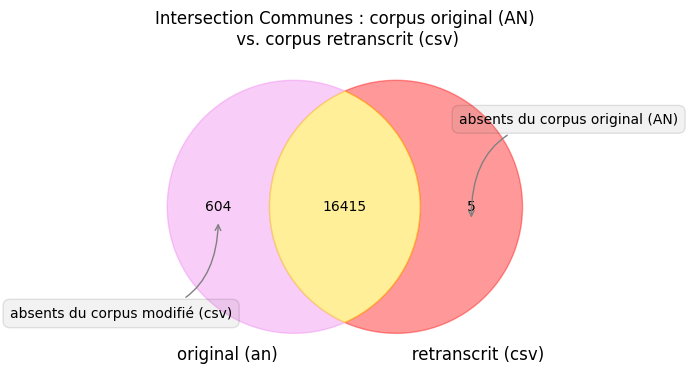

In [72]:
processed_set = set(processed_compare_df)
original_set = set(compare_original )
insee_set = set(df_insee)
intersection_original_processed = original_set.intersection(processed_set)
intersection_original_insee = original_set.intersection(insee_set)
intersection_processed_insee = insee_set.intersection(processed_set)

# affiche les intersections - exclusions du merge original vs. processed
# les montre (venn diagram) et les sauvegarde

from matplotlib import pyplot as plt

# define size of figure

plt.figure(figsize=(8,4))

v = mv.venn2_unweighted([original_set, processed_set], set_labels= ("original (an)   ", "   retranscrit (csv)"))
# mêmes resultats avec :
# v = mv.venn2([set(list(uniques_original[info_recherche[choix]])), set(list(uniques_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))

# choose color

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('11').set_color('gold')


# choose title

plt.title("Intersection "+noms[choix]+" : corpus original (AN)\n vs. corpus retranscrit (csv)")

# add some texts

plt.annotate('absents du corpus modifié (csv)', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents du corpus original (AN)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show(v)
# plt.savefig("original_vs_modifie_"+noms[choix]+".png", format = "png", dpi = 800)

In [73]:
# see the two exclusions with the venn librairy
saver = processed_set - intersection_original_processed
print(list(saver))
print(intersection_processed_insee)
# yes, i didnt need to merge with pandas i could have used venn librairy since the bgginning

['4049', '4019', '2168', '4170', '75120']
{'65433', '25002', '31280', '58081', '18118', '22197', '43089', '45082', '22340', '29212', '30174', '84002', '87143', '55502', '71585', '71276', '39407', '61288', '41172', '30185', '42197', '71528', '80071', '22100', '50400', '71411', '89145', '38148', '87109', '29169', '33463', '26316', '67356', '81322', '74276', '76172', '88029', '26347', '86106', '57336', '22154', '01389', '24299', '37068', '65266', '22028', '30033', '24585', '72331', '04102', '31476', '65421', '01243', '87159', '69280', '17364', '25631', '50271', '87111', '27684', '24296', '57193', '23147', '10255', '82055', '35121', '30252', '30328', '10110', '33123', '31145', '12268', '28080', '35039', '26342', '56106', '28335', '10111', '33328', '22122', '24498', '59127', '50045', '55481', '57356', '80373', '17354', '88044', '70296', '38540', '78643', '74025', '73054', '34317', '46319', '69157', '63345', '76451', '62197', '77379', '69212', '73129', '29186', '43065', '61094', '79058', '57

Text(-90, -50, 'processed U original\nneg. insee')

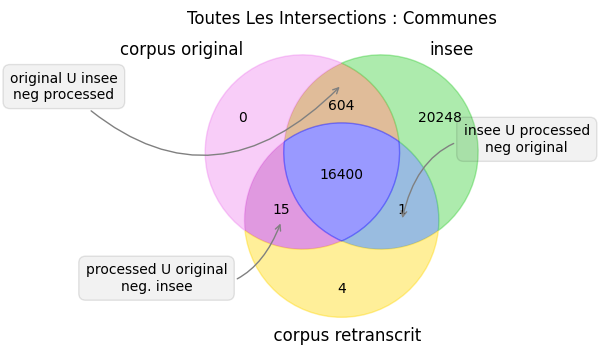

In [74]:
# diagram of the two corpus and the insee stats
# compare the three df :
# processed_compare_df
# compare_original
# df_insee

plt.figure(figsize=(8,4))

v3 = mv.venn3_unweighted([set(list(compare_original)), set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("corpus original  ","insee","  corpus retranscrit" ))
# index of each part, for design (100, 010, 110, 001, 101, 011, 111)

# define colors

v3.get_patch_by_id('100').set_color('violet')
v3.get_patch_by_id('001').set_color('gold')

v3.get_patch_by_id('111').set_color('blue')
v3.get_patch_by_id('010').set_color('limegreen')
# v3.get_patch_by_id('110').set_color('darkgreen')

# title

plt.title("Toutes Les Intersections : "+noms[choix])

# add some text for intersections

plt.annotate('original U insee\nneg processed', xy=v3.get_label_by_id('110').get_position() - np.array([0, -0.09]), xytext=(-200,-10),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('insee U processed\nneg original', xy=v3.get_label_by_id('011').get_position() - np.array([0, 0.05]), xytext=(90,50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('processed U original\nneg. insee', xy=v3.get_label_by_id('101').get_position() - np.array([0, 0.05]), xytext=(-90,-50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

# plt.show()

plt.savefig(noms[choix]+"_all", format = "png", dpi = 1000)



<Figure size 800x200 with 0 Axes>

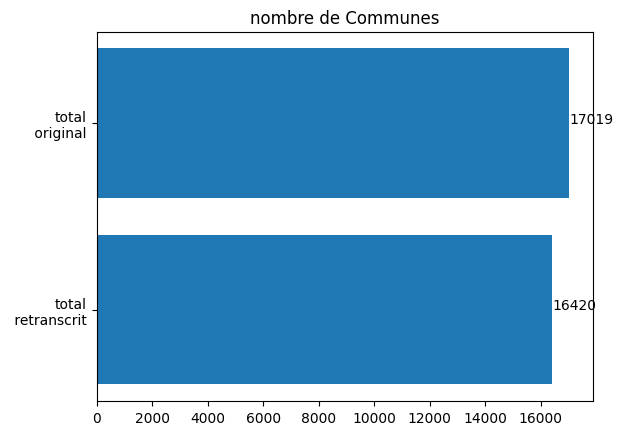

In [75]:
# show the number of <dpt or communes> for 1/insee, 2/original, 3/processed
#  and save

# values = np.array([shape_processed[0], original_shape[0], insee_shape[0]])
values = np.array([shape_processed[0], original_shape[0]])

# names = ("nb_processed", "nb_original", "nb_insee")
names = ("total\n retranscrit", "total\n original")

plt.figure(figsize=(8,2))
fig, ax = plt.subplots()
plt.barh(names, values)
for index, value in enumerate(values):
    plt.text(value, index,
             str(value))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('nombre de '+noms[choix])
plt.savefig(noms[choix]+"_data.png", format = "png", dpi = 1000)
plt.show()